## 12.17_프로젝트: CAM을 만들고 평가해 보자

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
import PIL
from PIL import Image
from tensorflow.keras import layers

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


### 2가지 실험 진행을 계획 -> 데이터를 옮기는 과정에서 시간이 많이 소요되는 문제.. => 추후 진행
1. Diabetic Retinopathy Detection 
- 관심있는 당뇨병성 망막병증 CAM, grad CAM 실험 진행  
2. RSNA penumonia detection은 bbox존재 iou계산 실험

In [61]:
# # xray 폐렴 탐지
# import tensorflow_datasets as tfds

# (ds_train, ds_test), ds_info = tfds.load(
#     'rsna_pneumonia_detection', 
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=Faㅠlse,  # 이미지와 bounding box를 사용
#     with_info=True
# )

# print(ds_info)

### 1. 데이터셋 구성 및 전처리

### 당뇨병성 망막병증 데이터

CSV 파일 내용 확인:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

총 85개의 이미지 파일 확인.
['19477_left.jpeg', '19441_right.jpeg', '111_left.jpeg', '19475_left.jpeg', '1943_right.jpeg']


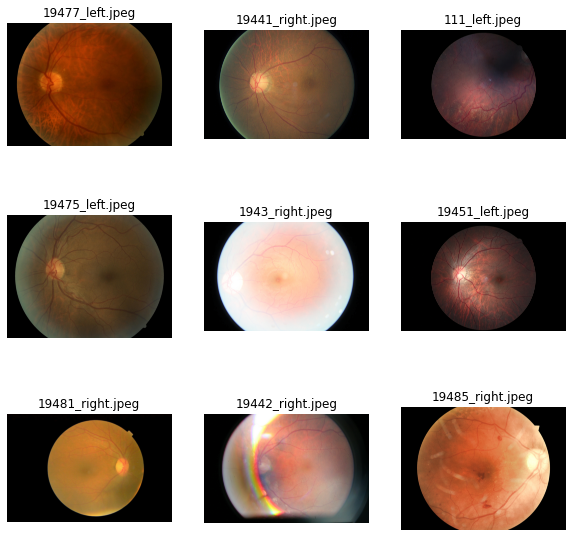

In [60]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# 경로 설정
image_folder_path = '/aiffel/aiffel/workplace/12.07_CAM'
label_csv_path = '/aiffel/aiffel/workplace/12.07_CAM/12.17_DB_trainLabels.csv'

# 라벨
label_df = pd.read_csv(label_csv_path)  
print("CSV 파일 내용 확인:")
print(label_df.head())

# 모든 JPEG 파일 불러오기
image_files = [file for file in os.listdir(image_folder_path) if file.endswith(".jpeg")]
print(f"\n총 {len(image_files)}개의 이미지 파일 확인.")
print(image_files[:5])  # 일부 파일 출력

# 이미지 확인
def show_sample_images(image_folder, image_files, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(image_files[:num_images]):
        image_path = os.path.join(image_folder, image_name)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(image_name)
        plt.axis("off")
    plt.show()

show_sample_images(image_folder_path, image_files)

- 좌상단부터 순서대로 class 0 , 2, 0, / 0, 0, 1, / 0, 0, 2 
- 각 class는 질병의 진행정도와 관련 있습니다.
- 당초 목적은, 위 당뇨병성 망막병증의 데이터들을 어떻게 질병의 진행정도(클래스 0~4)에 따라 분류하는지 CAM을 통해 확인하고 싶었습니다.
- 하지만 이미지들 및 각 이미지에 해당하는 라벨을 확인한 결과, 위 데이터 양만으로는 충분한 학습이 어려울 것이라 생각이 들었습니다. (약 80개이상의 데이터를 넣는것만 하더라도Aiffel 폴더에는 시간이 오래 걸리는 문제가 있습니다ㅠ)
- 추후 시간이 된다면, 좀더

### 2. ResNet50을 활용한 CAM 모델 구성 및 학습, 적용

In [7]:
# Normalize and resize
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용 -> 이미 사전에 Global Average Pooling 레이어 적용!
)
x = base_model.output

# Softmax 활성화 함수를 사용한 Fully Connected Layer 추가 # preds = ADD_YOUR_DENSE_LAYER(x)
preds = layers.Dense(num_classes, activation='softmax', name="predictions")(x) # 클래스 수에 맞게 출력 노드를 설정

# 최종 CAM 모델 생성
cam_model = keras.Model(inputs=base_model.input, outputs=preds)
Cam_model.summary()


In [ ]:
# get_one() 데이터셋에서 한장식 뽑을 수 있도록
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
# 1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    return cam_image

In [ ]:
# 2. 만든 함수로 CAM 이미지를 생성합시다.
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)


In [ ]:
# 3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.
def visualize_cam_on_image(image, cam_image):
    # TODO: blend image
    merged_image = None
    return merged_image

# visualize_cam_on_image() 함수 사용

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)



### 3. Grad-CAM 구현 및 적용 
이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.   

만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.  

위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.  

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image

### 4. 바운딩 박스 구하기 
1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.  

2. 1)에서 얻은 바운딩 박스를 시각화해 보세요.

### 5. IoU 구하기
정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.  

CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.  


In [ ]:
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou

### 루브릭 
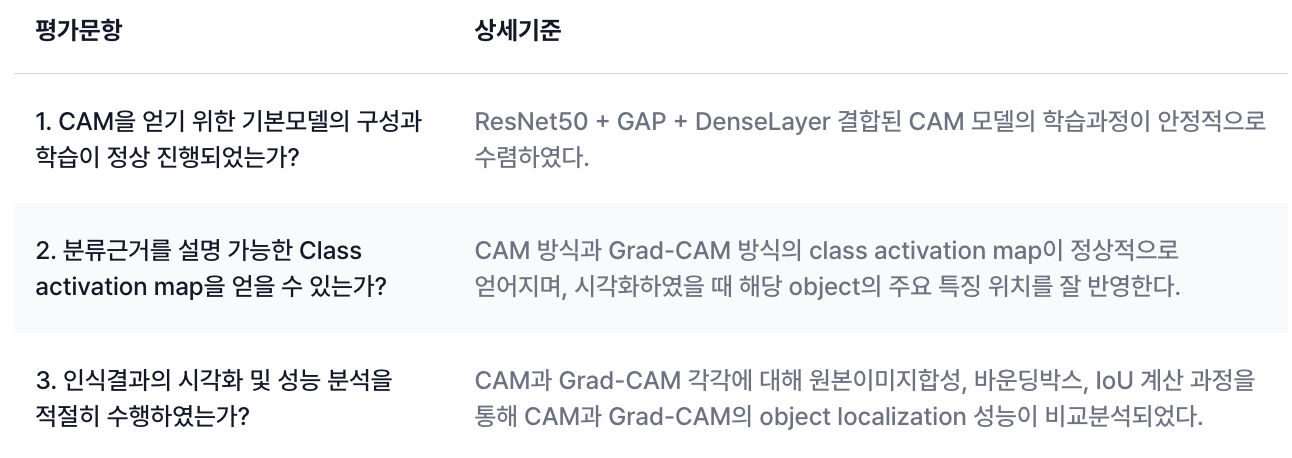

### 8-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기
CAM(Class Activation Map) 은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있습니다. 반면에 Grad-CAM은 이러한 제약이 없죠.

이번 시간에는 CAM과 Grad-CAM, 이 두 가지를 모두 구현해 보겠습니다.
우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠습니다. Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하기 때문입니다.

CAM은 클래스에 대한 활성화 정도를 나타낸 지도 입니다. 따라서 기본적으로 우리의 모델은 분류(classfication) 를 수행하는 모델이어야 합니다. 하지만 우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

Tensorflow Datasets의 카탈로그에서 이러한 데이터를 확인할 수 있는데요. 여기서는 stanford_dogs 데이터셋을 사용하겠습니다. 이는 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 바운딩 박스(bounding box) 정보를 포함하고 있습니다. 그럼 필요한 라이브러리와 데이터셋을 준비하고 시작하겠습니다.

-> FeaturesDict로 감싸져있고, 'image', 'image/filename', 'label', 'objects' 총 4개의 keys를 가짐.






In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
# stanford_dogs 데이터셋은 12,000장의 학습용 데이터셋과 8,580장의 평가용 데이터셋으로 구성되어있습니다. tfds.load()를 활용해서 데이터셋을 다운로드 해주세요.
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


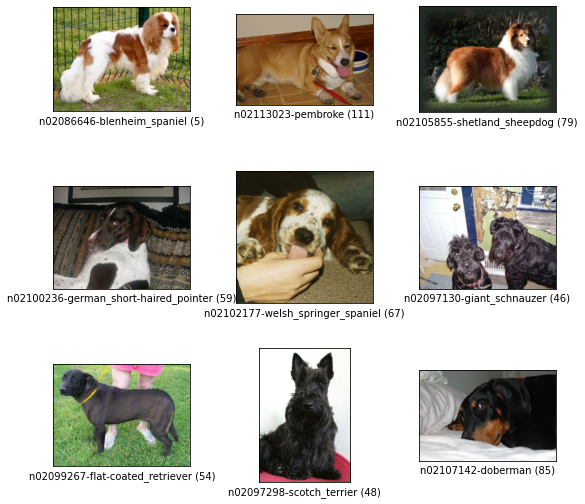

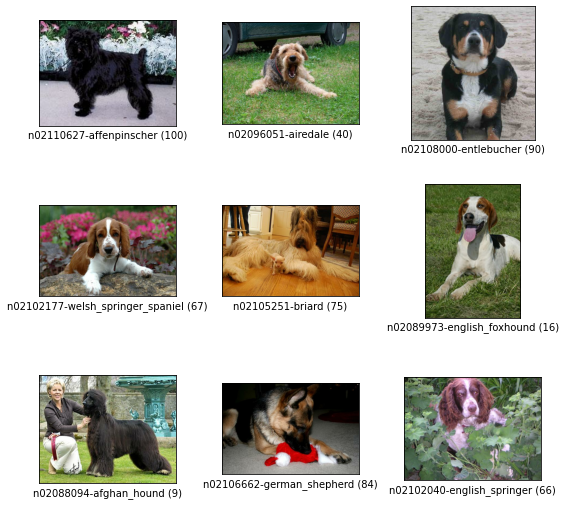

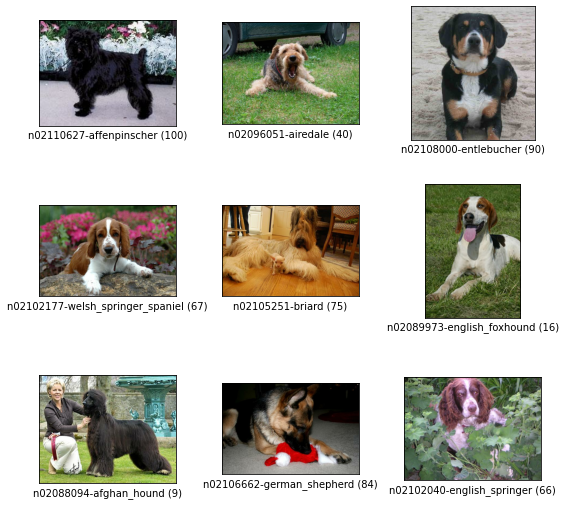

In [12]:
# tfds.show_examples() 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있습니다.
tfds.show_examples(ds_train, ds_info)
tfds.show_examples(ds_test, ds_info)

### 8-3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보
원본 이미지 위에 물체의 위치정보는 어떻게 시각화하여 표시할 수 있을까요? 데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인해 봅시다.






In [13]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

먼저 image와 label은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스입니다. 몇 번 보신 적 있으신가요? 그런데 조금 새로운 키(key)가 있습니다. bbox는 무엇일까요? bbox(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법입니다. 위에서 확인한 바로는 BBoxFeature이라는 타입으로 정의되어 있습니다.

바운딩 박스를 표시하는 방법들
바운딩 박스를 라벨링하는 방법은 아주 다양합니다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법입니다.

'xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.
(예) (x_center, y_center, width, height)
x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.
'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다.
(예) (x_min, x_max, y_min, y_max)
좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.
위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있습니다. 따라서 새로운 데이터셋을 접하거나 라이브러리를 활용하실 때는 간단한 바운딩 박스 정보라도 한 번 더 표기법을 확인하고 넘어가는 것이 좋습니다.

BBoxFeature

Q. 주어진 데이터셋에서 BBoxFeature 타입으로 표기된 bbox 필드는 어떤 방식으로 바운딩박스를 라벨링하고 있나요? 위에 제시된 텐서플로우 튜토리얼 링크를 통해 확인해 봅시다.  
해당 bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미하게 됩니다.








### 8-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기
이번에는 본격적으로 CAM을 얻어내기 위한 모델을 만들어 보겠습니다. 미리 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.

참고로, 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어입니다.

구현해 보기
아래에서 직접 ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성해 주세요. CAM 모델의 구조가 생각나지 않는다면, Lecture 노드나 관련 내용을 참고해 완성해 보세요.






In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용 -> 이미 사전에 Global Average Pooling 레이어 적용!
)
x = base_model.output

# Softmax 활성화 함수를 사용한 Fully Connected Layer 추가 # preds = ADD_YOUR_DENSE_LAYER(x)
preds = layers.Dense(num_classes, activation='softmax', name="predictions")(x) # 클래스 수에 맞게 출력 노드를 설정

# 4. 최종 CAM 모델 생성
cam_model = keras.Model(inputs=base_model.input, outputs=preds)


CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없습니다. 다만 마지막 fully connected layer 대신 GAP을 사용해주어야 합니다. 우리의 경우 ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있습니다.



In [17]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Q. CAM은 특성 맵(feature map)을 사용해 만듭니다. 위 레이어들 중 우리가 사용하는 특성 맵은 어떤 레이어의 출력값일까요? 해당 레이어의 이름을 찾아보세요.  
conv5_block3_out의 output이 feature map이 됩니다.   
따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 됩니다.




### 8-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기
이제 학습을 위한 과정은 이전과 비슷합니다.

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행하며, 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성합니다.

input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외해 주었습니다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.






In [20]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(                 # normalize_and_resize_img 함수를 데이터셋 ds에 병렬로 적용
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size) # 배치사이즈 만큼 묶어서 모델에 입력
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # cpu gpu 병렬작업, 적절한 버퍼크기 설정
    return ds

print('슝=3')

슝=3


In [21]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


이제 모델을 컴파일하고 학습시킵시다. 여기서는 맛보기로 2 Epoch 만 학습시켜 봅시다.😊 (뒷 부분에서는 미리 준비해둔 학습된 가중치를 불러와서 모델에 적용할 예정입니다.)






In [22]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


In [23]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 202s 203ms/step - loss: 2.2287 - accuracy: 0.4396 - val_loss: 3.3503 - val_accuracy: 0.2248
Epoch 2/2
750/750 [==============================] - 153s 204ms/step - loss: 0.6228 - accuracy: 0.8365 - val_loss: 1.1437 - val_accuracy: 0.6631


In [24]:
# Q. '/aiffel/class_activation_map' 에 'cam_model1.h5'을 저장하세요.

import os

cam_model_path = '/aiffel/aiffle/workplace/12.07_CAM/cam_model1.h5'

# [[YOUR CODE]]
cam_model.save(cam_model_path) # model의 구조, 가중치, 옵티마이저 상태까지 포함해서 저장

print(f"모델이 {cam_model_path}에 성공적으로 저장되었습니다.")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


모델이 /aiffel/aiffle/workplace/12.07_CAM/cam_model1.h5에 성공적으로 저장되었습니다.


### 8-6. CAM
이제 학습된 모델을 활용하여 CAM을 생성해 볼 것입니다. 메모리 부족으로 인해 이후 실습에 문제가 발생할 수 있으므로, 이번 스텝 시작 전에 커널을 재시작할 것을 권합니다.






In [25]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


이제 학습된 모델에서 CAM을 생성해 봅시다. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.






In [26]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


67


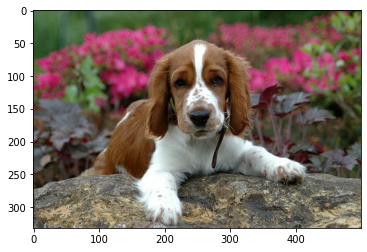

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [29]:
import os
cam_model_path = '/aiffel/aiffle/workplace/12.07_CAM/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


#### 이제 데이터가 준비되었으니 CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러와 봅시다.

    CAM을 생성하기 위해서는 (1) 특성 맵, 
    (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 
    (3) 원하는 클래스의 출력값이 필요합니다. 
    또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 
    이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

    generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, 
    feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 
    마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.

In [30]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    # model.layers[-3].output: 마지막에서 세 번째 레이어(Conv 레이어)의 출력 (dens,pooling 전!=GAP이전 Conv 레이어의 아웃풋)
    # tf.expand_dims(img_tensor, 0): 배치 차원을 추가합니다. 입력 형태는 (1, height, width, channels)가 됩니다.
    # predictions: 모델의 최종 클래스 예측 확률.
    # conv_outputs: Conv 레이어의 출력 Feature Map.
    
    
    # 모델의 weight activation은 마지막 layer에 있습니다. CAM 계산 준비
    class_weights = model.layers[-1].get_weights()[0] 
    # model.layers[-1]: 최종 Dense 레이어의 가중치를 가져오기
    
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) # height,width
    for i, w in enumerate(class_weights[:, class_idx]):
        # class_weights[:, class_idx]: 특정 클래스(class_idx)의 가중치를 가져옵니다.
        # conv_outputs의 i번째 채널과 i번째 weight(w)를 곱해서 누적하면 활성화된 정도(강도 계산)가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다. 0~1로 스케일링
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

"""
1. 위코드로 특정 클래스의 활성화 맵(CAM)이 생성
2. CAM은 이미지 내에서 해당 클래스와 관련된 영역 강조
3. 이를 통해 모델이 어떤 부분을 보고 특정 클래스를 예측했는지 확인 가능
"""

'\n1. 위코드로 특정 클래스의 활성화 맵(CAM)이 생성\n2. CAM은 이미지 내에서 해당 클래스와 관련된 영역 강조\n3. 이를 통해 모델이 어떤 부분을 보고 특정 클래스를 예측했는지 확인 가능\n'

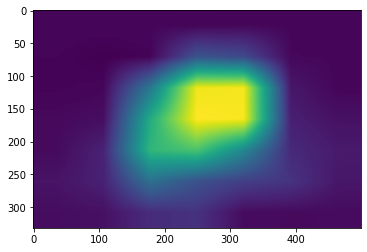

In [45]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

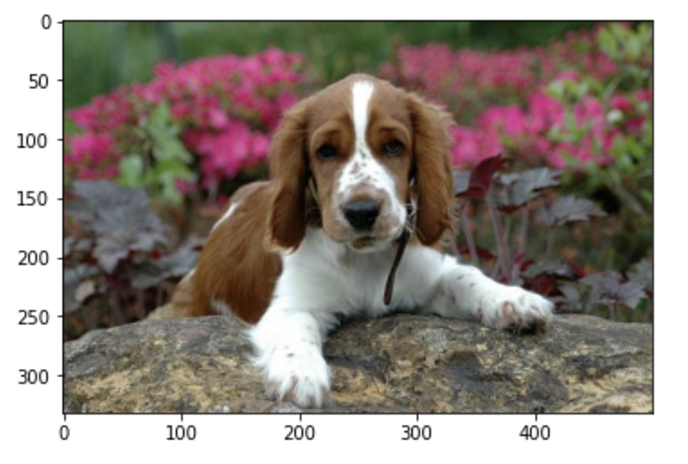

In [46]:
# 이렇게 그려진 CAM 이미지를 원본 이미지와 합쳐 봅시다.
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


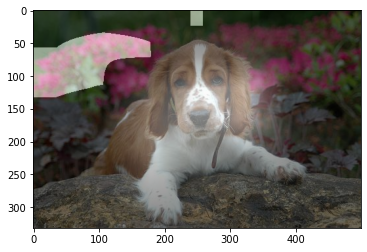

In [49]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

어떤가요? 생성된 CAM이 개를 식별하는데 중요한 이미지 부분을 잘 포착하고 있나요? 주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 경향이 있는데, 이것은 사람이 개를 식별할 때 유의해서 보는 부분과 일맥상통합니다.



### 8-7. Grad-CAM
이번에는 Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용합시다.

우선 새로운 이미지를 뽑아봅시다.






40


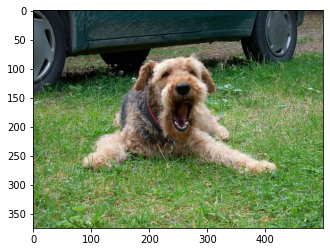

In [50]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

이번에는 Grad-CAM을 이용해서 CAM을 만들어 봅시다.

grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됩니다.

이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.

아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.






In [60]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    # Model 클래스는 Keras의 Functional API를 사용해 새로운 모델을 정의 = Keras의 Model 클래스는 입력 텐서와 출력 텐서를 기반으로 새로운 모델을 생성
    # activation_layer는 사용자가 Grad-CAM에서 주목하고 싶은 레이어의 이름을 의미
    #	1.	activation_layer의 출력 → 이 레이어의 Feature Map이 필요합니다.
    #   2.	모델의 최종 출력 → 이 값으로부터 **Gradients (기울기)**를 구해야 합니다.
    
    
    # Gradient를 얻기 위해 tape를 사용합니다. with 블록 안에 작성된 연산들에 대한 **기울기(gradient)**를 추적
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        # grad_model의 출력은 Feature Map과 최종 예측값(pred=Softmax 레이어를 거친 클래스별 예측값)입니다.
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다. 
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.
        # loss에 대해 conv_output(Feature Map)의 **기울기(gradient)**를 계산
        # 이 기울기는 각 Feature Map 채널이 해당 클래스에 얼마나 기여했는지 나타냄
        
    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

""" loss = pred[:, class_idx]
    pred = [0.1, 0.9]  # 강아지일 확률: 10%, 고양이일 확률: 90%
	•	class_idx: Grad-CAM이 집중하고 싶은 클래스의 인덱스입니다.
    예를 들어, class_idx = 1이면 고양이에 해당하는 클래스입니다.
	•	pred[:, class_idx]:
	•	원하는 클래스 **class_idx**에 대한 확률값을 의미합니다.
	•	예를 들어:
	•	pred = [0.1, 0.9]이고 class_idx = 1이면 pred[:, class_idx] = 0.9입니다.
    
    *** 중요
    •	이때 Loss를 해당 클래스의 확률값으로 설정하면:
	•	모델이 예측한 클래스 확률이 높을수록 해당 클래스에 더 잘 예측한 것입니다.
	•	이 확률값에 따른 **Gradient(기울기)**를 계산하면,
        모델이 어떤 Feature Map 채널이 해당 클래스 예측에 중요한 기여를 했는지 알 수 있습니다.
"""

""" output = conv_output[0]
	•	conv_output은 Feature Map이 배치 단위로 반환된 형태입니다.
	•	conv_output[0]을 통해 첫 번째 이미지의 Feature Map만 선택합니다.
	•	예를 들어, conv_output이 (1, 7, 7, 2048)라면 conv_output[0]은 (7, 7, 2048)입니다.
"""

# print('슝=3')

' output = conv_output[0]\n\t•\tconv_output은 Feature Map이 배치 단위로 반환된 형태입니다.\n\t•\tconv_output[0]을 통해 첫 번째 이미지의 Feature Map만 선택합니다.\n\t•\t예를 들어, conv_output이 (1, 7, 7, 2048)라면 conv_output[0]은 (7, 7, 2048)입니다.\n'

Q. 위 코드에서 with tf.GradientTape() as tape: 를 사용하는 이유를 생각해봅시다.

  
Grad-CAM에서 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용하기 때문입니다.  

이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 이전 스탭의 cam_model.summary() 결과에서 찾을 수 있습니다.


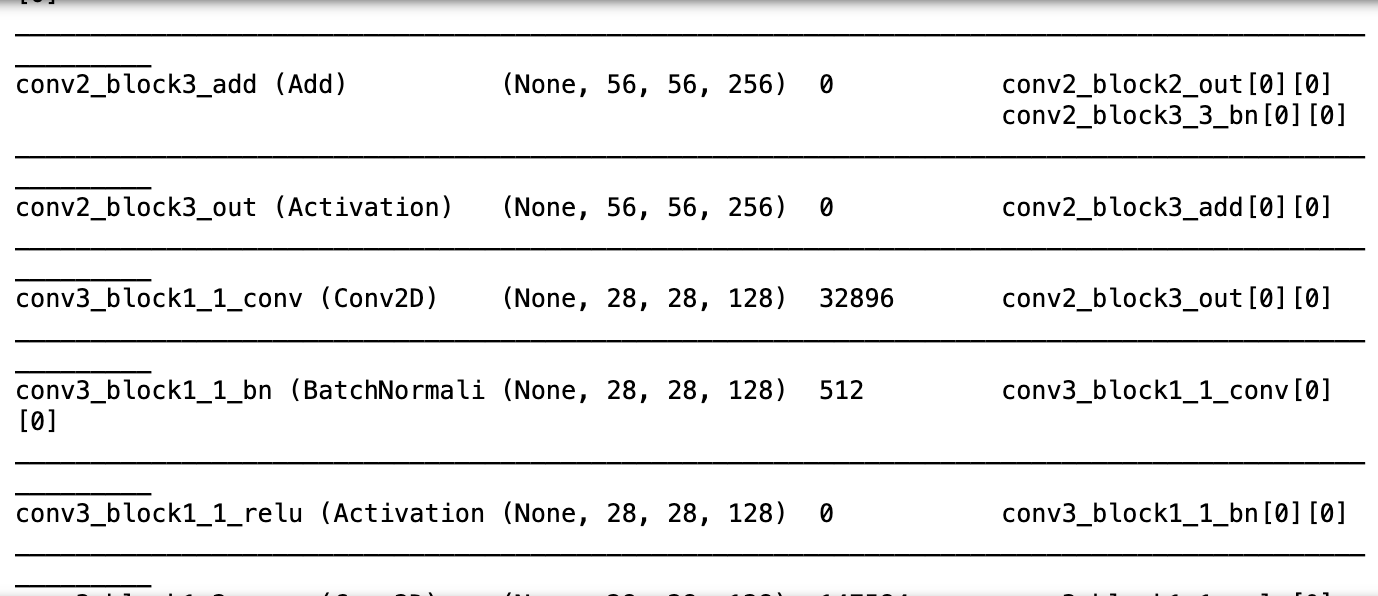




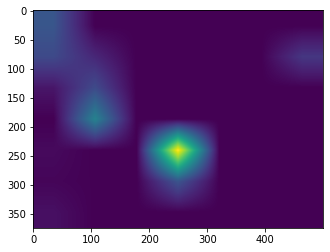

In [61]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

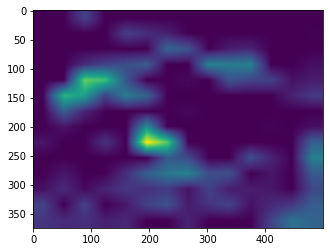

In [62]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

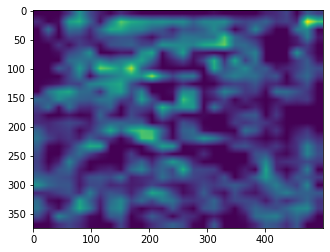

In [63]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

###  8-8. Detection with CAM
바운딩 박스
마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠습니다.

우선 새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아봅시다.

84


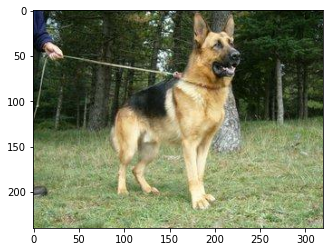

In [65]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

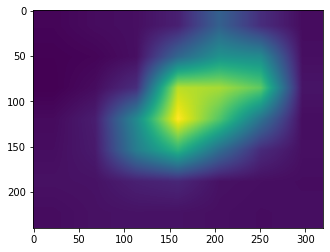

In [66]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이전 스텝에서 만들었던 generate_cam()을 활용해서 CAM 이미지를 뽑았습니다. 아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다. boxPoints()로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 int 자료형으로 변환해 줍니다.






In [68]:
# (CAM) 이미지에서 Bounding Box(경계 상자)를 추출하는 함수
# CAM 이미지에서 특정 클래스가 활성화된 영역을 기준으로 경계 상자를 찾아 반환
def get_bbox(cam_image, score_thresh=0.05):
    # cam_image: CAM 이미지, 값이 0과 1 사이의 활성화 점수를 가진 이미지 threshold 0.05(낮은 활성화) 미만 무시
    low_indicies = cam_image <= score_thresh
    # low_indicies: cam_image에서 점수가 score_thresh 이하인 픽셀들의 위치(Boolean 배열)
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    # 검출된 첫 번째 Contour를 선택 -> 첫번째 contour가 가장 큰 활성화 영역임
    rotated_rect = cv2.minAreaRect(cnt) # 주어진 contour 감싸는 가장 작은 회전된 사각형
    rect = cv2.boxPoints(rotated_rect) # 곡지점 구하기 4개 좌표
    rect = np.int0(rect) # 정수형 변환
    return rect # 좌표 4개 반환 
"""
	•	cv2.findContours: 이미지에서 **Contour(경계선)**를 찾아주는 OpenCV 함수입니다.
	•	cv2.RETR_TREE: 계층적 구조로 모든 Contour를 찾아냅니다.
	•	cv2.CHAIN_APPROX_SIMPLE: Contour를 간소화해 꼭지점만 반환합니다.
	•	contours: 검출된 Contour들의 리스트입니다. 활성화 영역의 경계선입니다.
	•	_: 계층 구조를 나타내지만 여기서는 사용하지 않으므로 _로 무시합니다.
"""
print('슝=3')

슝=3


In [69]:
rect = get_bbox(cam_image)
rect

array([[ 69,   0],
       [294,   0],
       [294, 201],
       [ 69, 201]])

cam_image에서 bbox를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있습니다.






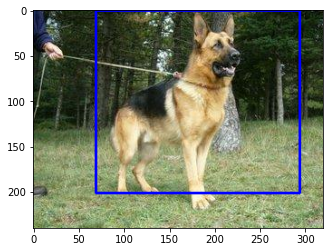

In [70]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union
위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 바운딩 박스를 얻을 수 있었습니다. 그럼 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할 수 있을까요?

content img
IoU(Intersection over Union) 는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.

#### Q. IoU(Intersection over Union)의 계산 절차를 조사하고, 특징을 정리해보세요.


첫번째, 두 개의 영역 또는 객체 간의 겹치는 부분인 교차 영역을 계산합니다. 이는 두 영역이 얼마나 겹치는지를 나타냅니다. 두번째, 두 개의 영역 또는 객체 간의 합집합 영역을 계산합니다. 이는 두 영역이 전체적으로 얼마나 많은 공간을 차지하는지를 나타냅니다. 세번째, IoU를 계산하기 위해 교차 영역을 합집합 영역으로 나눕니다.

IoU는 보통 0과 1 사이의 값을 가지며, 1에 가까울수록 두 개의 영역이 완전히 일치하거나 매우 유사함을 나타냅니다. 0에 가까울수록 두 영역이 겹치지 않거나 매우 다른 영역임을 나타냅니다.






In [71]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [72]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환해 봅시다.
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.215625, 0.8375, 0.91875]

In [73]:
#이 데이터의 ground truth bbox를 확인해 봅시다.
item['objects']['bbox']

array([[0.     , 0.23125, 0.925  , 0.73125]], dtype=float32)

어떤가요? CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷하게 얻어졌나요? 이 둘이 얼마나 유사한지를 IoU를 계산해서 확인해 봅시다.






In [74]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# 예시로 생각해보기
# boxA = [2, 2, 5, 5] (y_min, x_min, y_max, x_max)
# boxB = [3, 3, 6, 6]
print('슝=3')

슝=3


In [75]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6619326890396472